해당 파일은 사용자가 이미지를 넣었을 때, <br/>해당 이미지 임베딩값과 가장 가까운 임베딩값을 가지는 연예인 이미지를 반환해줍니다.<br/>*save_variable.ipynb*를 이용하여 *embedding.data*와 *embedding_info.data*가 저장되었다고 가정하고 있습니다.

사용자가 직접 변수값을 부여해줘야 하는 부분은 **0.변수설정**입니다. <br/>

추후 보안해야 하는 부분은 웹툰 이미지가 들어올 때,<br/>웹툰 얼굴을 crop해주는 부분입니다.

In [103]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import pickle

workers = 0 if os.name == 'nt' else 4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [156]:
# 범례 한글 깨짐 현상 해결
# https://ehpub.co.kr/47-matplotlib%EC%9D%98-rc%EC%97%90-%ED%95%9C%EA%B8%80-%ED%8F%B0%ED%8A%B8%EB%A5%BC-%EC%84%A4%EC%A0%95%ED%95%A0-%EC%88%98-%EC%9E%88%EC%96%B4%EC%9A%94/
# https://koosco.tistory.com/38
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

#### 0.변수설정 

In [157]:
# data_path: 연예인 폴더들을 포함하는 상위 폴더
data_path = "/opt/ml/facenet_pytorch/data/actor_data"

# embedding_saving_path: embedding vector 변수가 저장되는 파일 위치
embedding_saving_path = "/opt/ml/facenet_pytorch/data/embedding.data"

# embedding_info_path: embedding vector에 해당하는 이미지 경로정보가 저장되는 파일 위치
embedding_info_path = "/opt/ml/facenet_pytorch/data/embedding_info.data"

# input_path: input 이미지 경로
# input_path = '/opt/ml/제니.jpg'
input_path = '/opt/ml/쿤타.jpg'

# k: input이미지 임베딩 값과 가까운 k개의 연예인 이미지 반환
k = 5

#### 1. MTCNN 모듈 및 InceptionResnetV1 모듈 정의

In [158]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [159]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

#### 2. pickle을 이용하여 변수 로드 수행

In [160]:
# embeddings 로드
with open(embedding_saving_path, 'rb') as f:
    embeddings = pickle.load(f)

In [161]:
# path_infos 로드
with open(embedding_info_path, 'rb') as f:
    path_infos = pickle.load(f)

#### 3. input 이미지의 embedding vector 계산

In [162]:
def caculate_embedding(img_path: str, is_webtoon: bool):
    img = cv2.imread(img_path)
    try:
        if type(img) == np.ndarray and len(img.shape) == 3 and img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if is_webtoon:
                ###############################
                # To-do: 웹툰의 경우, 웹툰 얼굴 detection
                ###############################
                x_aligned = img
            else: # 실제 인물 사진이면 mtcnn 수행
                x_aligned = mtcnn(img, return_prob=False)

            plt.imshow((x_aligned * 128 + 127.5).cpu().numpy().astype(np.Uint64).transpose((1,2,0)))
            plt.title(f'참고. crop된 결과물({input_path})')

            # crop된 사진 embedding vector 구하기
            # input_embedding = resnet(torch.tensor(x_aligned).unsqueeze(0).to(device)).detach().cpu()
            input_embedding = resnet(x_aligned.clone().detach().unsqueeze(0).to(device)).detach().cpu()
        else:
            raise Exception('입력 이미지가 유효하지 않습니다.')
    except Exception as e:
        print(e)

    return input_embedding

input_embedding.shape: torch.Size([512])


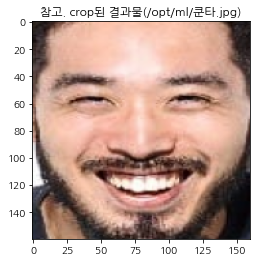

In [163]:
input_embedding = caculate_embedding(input_path, False).squeeze()
print(f'input_embedding.shape: {input_embedding.shape}')

#### 4. input이미지의 embedding 값과 제일 가까운 k개의 연예인 이미지 반환

In [164]:
def return_nearest_images(input_embedding, embeddings):
    dist = np.array([(input_embedding - embedding).norm().item() for embedding in embeddings])
    idx_sort = dist.argsort()
    return dist, idx_sort

In [165]:
dist, idx_sort = return_nearest_images(input_embedding, torch.tensor(embeddings))

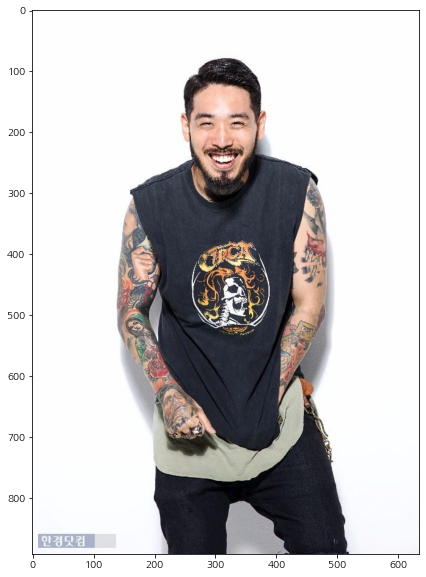

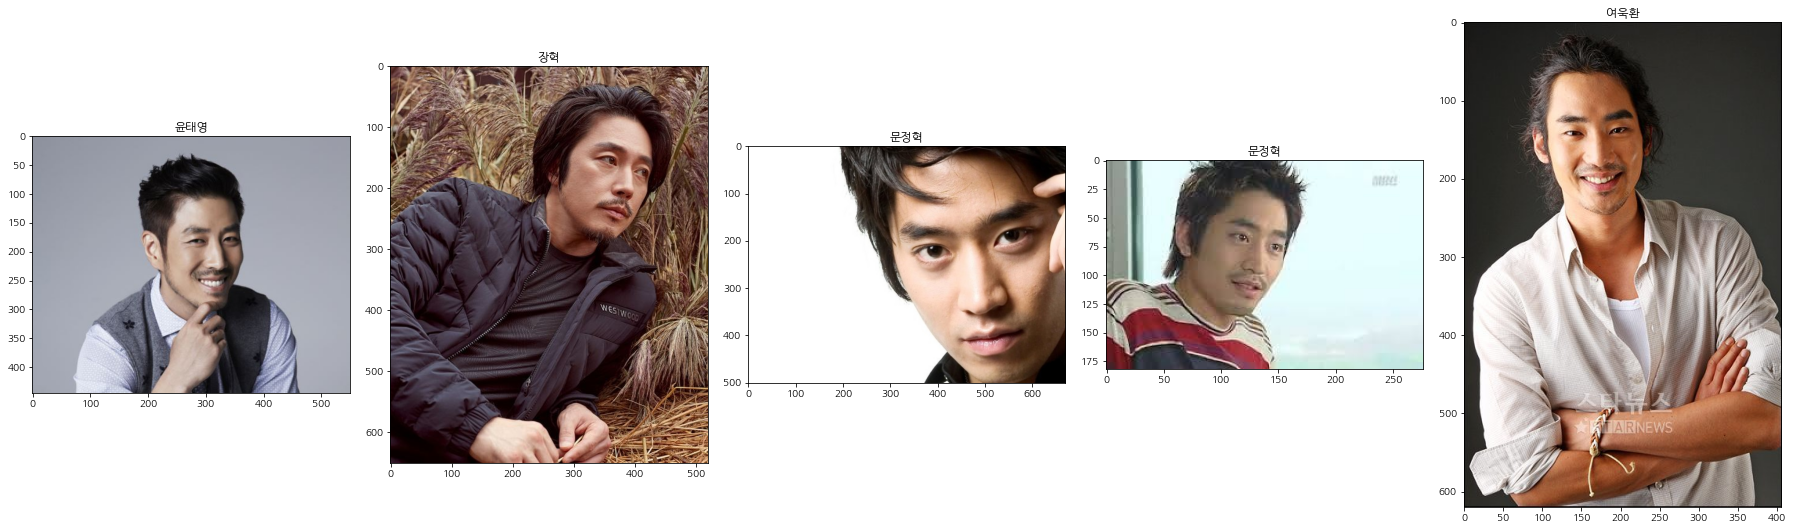

In [166]:
input_img = cv2.imread(input_path)
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(input_img)

fig, ax = plt.subplots(1, k, figsize=(25, 25*k))
fig.tight_layout()
for i in range(k):
    path = os.path.join(data_path, path_infos[idx_sort[i]][0], path_infos[idx_sort[i]][1])
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i].imshow(img)
    ax[i].set_title(path_infos[idx_sort[i]][0])
